# Visualize COCO features

1. visualize coco features
2. identify pca-one; what is its cosine similarity with the residual (should be very high)
3. move along the direction, plot 1-dim loss landscape. [-2,-1,-0.5,0,0.5,1,2]
    - need to have a fn(scalar,), output loss. 


In [1]:
import argparse
import os
import random
import shutil
import time
import warnings
from enum import Enum
import pickle
import numpy as np
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn

def my_norm(x):
    return x/np.linalg.norm(x, axis=-1, keepdims=True)

In [2]:
pickle_path = './features/feature_dump_val.pkl'
with open(pickle_path, 'rb') as pkl_file:
    data_dict = pickle.load(pkl_file)
    assert len(data_dict['clip_image_features_list']) == len(data_dict['clip_text_features_list'])
    # assert len(data_dict['clip_image_features_list']) == len(data_dict['target_image_features_list'])
    print('Number of image-text pairs', len(data_dict['clip_image_features_list']))

Number of image-text pairs 5000


Euclidean distance between mass centers: 0.8221026
Explained variation per principal component: [0.2524753  0.03142844 0.02358807 0.02154439 0.01690736 0.0156801 ]
sum 0.36162365041673183


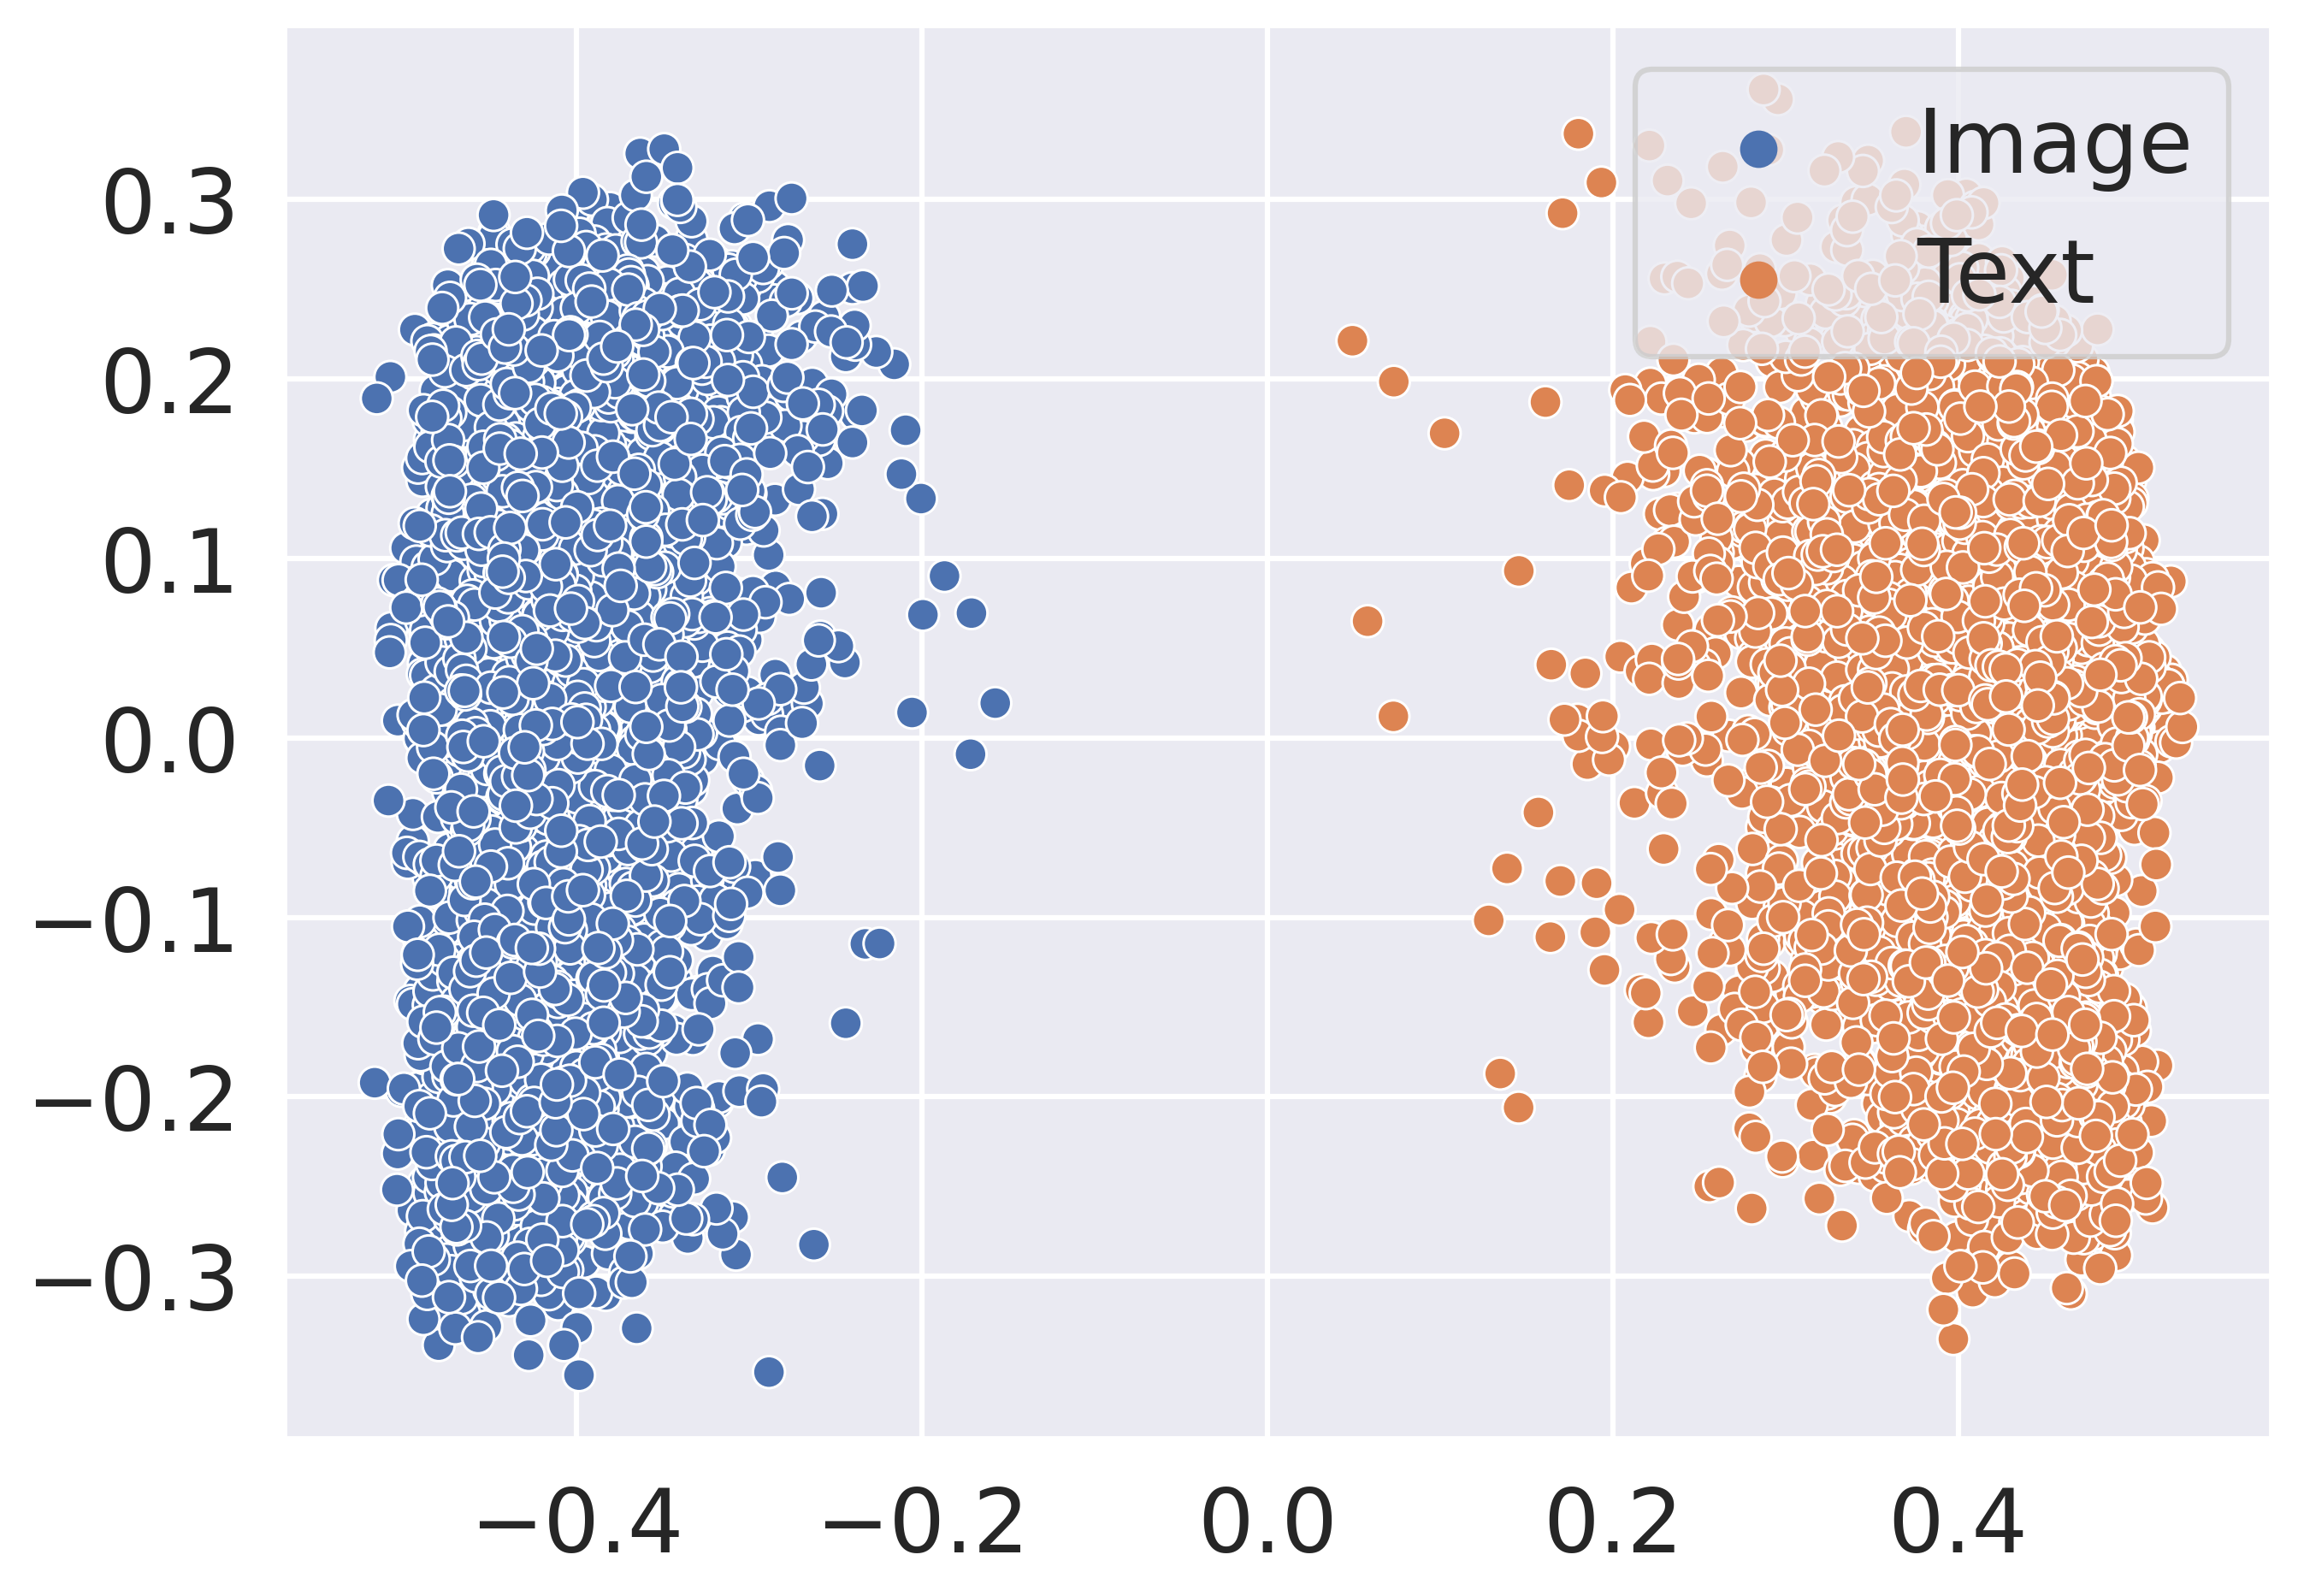

In [17]:
# visualize.

from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# sns.set(font_scale=2)  # crazy big
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
sns.set_theme()
sns.set_context("talk", font_scale=1.5 ) # paper, notebook, talk, and poster; font_scale=1.5,

def plot_clip_text_img_features(image_features_np, text_features_np):

    image_features_np /= np.linalg.norm(image_features_np, axis=-1, keepdims=True) + 1e-12
    text_features_np /= np.linalg.norm(text_features_np, axis=-1, keepdims=True) + 1e-12

    print('Euclidean distance between mass centers:', 
    np.linalg.norm(
        image_features_np.mean(axis=0) - text_features_np.mean(axis=0)
        )
    )
    pca = PCA(n_components=6)
    pca.fit( np.concatenate((image_features_np,text_features_np), axis=0) )
    # pca.fit( text_features_np )
    
    pca_result = pca.transform(image_features_np)
    print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_), )
    print('sum', sum(pca.explained_variance_ratio_))
    df = pd.DataFrame()
    df['COCO Caption'] = ['Image'] * len(image_features_np)
    df['pca_one'] = pca_result[:,0]
    df['pca_two'] = pca_result[:,1] 
    df['pca_three'] = pca_result[:,2]

    pca_result2 = pca.transform(text_features_np)
    # print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_), )
    # print('sum', sum(pca.explained_variance_ratio_))
    df2 = pd.DataFrame()
    df2['COCO Caption'] = ['Text'] * len(text_features_np)
    df2['pca_one'] = pca_result2[:,0]
    df2['pca_two'] = pca_result2[:,1] 
    df2['pca_three'] = pca_result2[:,2]

    df = pd.concat([df, df2], ignore_index=True)

    plt.figure(figsize=(10,7.3))
    p1 = sns.scatterplot(
        x="pca_one", y="pca_two",
        # x="pca_three", y="pca_two",
        hue="COCO Caption",
        data=df,
        # legend=False,
    )
    plt.xlabel("")
    plt.ylabel("")
    plt.legend(loc='upper right')
    # for pair_id in range(len(image_features_np)):
    #     x = [df['pca_one'][pair_id], df2['pca_one'][pair_id]]
    #     y = [df['pca_two'][pair_id], df2['pca_two'][pair_id]]
    #     plt.plot(x, y, '-', color='grey', alpha=0.5, linewidth=0.1)

    return pca

pca = plot_clip_text_img_features(data_dict['clip_image_features_list'], data_dict['clip_text_features_list']) 


In [18]:
# give two lists of features, calculate loss

def calculate_val_loss(image_features_np, text_features_np, logit_scale = 1.000):

    # normalized features
    image_features_np /= np.linalg.norm(image_features_np, axis=-1, keepdims=True) + 1e-12
    text_features_np /= np.linalg.norm(text_features_np, axis=-1, keepdims=True) + 1e-12

    total_loss_list = list()

    loss_img = nn.CrossEntropyLoss()
    loss_txt = nn.CrossEntropyLoss()

    BATCH_SIZE = 50 # 5000 in total. 
    for idx in range(len(image_features_np)//BATCH_SIZE):
        
        with torch.no_grad():
            image_features = torch.from_numpy(image_features_np[idx*50:(idx+1)*50])
            text_features  = torch.from_numpy(text_features_np[idx*50:(idx+1)*50])        
        
            # cosine similarity as logits
            logits_per_image = logit_scale * image_features @ text_features.t()
            logits_per_text = logits_per_image.t()

            # # symmetric loss function
            labels = torch.arange(BATCH_SIZE,dtype=torch.long)#.cuda()
            loss_i = loss_img(logits_per_image, labels)
            loss_t = loss_txt(logits_per_text.T, labels)
            total_loss = (loss_i + loss_t)/2
            
            total_loss_list.append(total_loss.item())
    avg_val_loss = np.mean(total_loss_list)
    # print('avg_val_loss', avg_val_loss)
    return avg_val_loss

avg_val_loss = calculate_val_loss(data_dict['clip_image_features_list'], data_dict['clip_text_features_list'])

In [19]:

def plot_features_given_pca(image_features_np, text_features_np, pca, draw_figure=False):

    image_features_np /= np.linalg.norm(image_features_np, axis=-1, keepdims=True) + 1e-12
    text_features_np /= np.linalg.norm(text_features_np, axis=-1, keepdims=True) + 1e-12
    
    pca_result = pca.transform(image_features_np)
    # print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_), )
    # print('sum', sum(pca.explained_variance_ratio_))
    df = pd.DataFrame()
    df['COCO Caption'] = ['Image'] * len(image_features_np)
    df['pca_one'] = pca_result[:,0]
    df['pca_two'] = pca_result[:,1] 
    df['pca_three'] = pca_result[:,2]


    pca_result2 = pca.transform(text_features_np)
    # print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_), )
    # print('sum', sum(pca.explained_variance_ratio_))
    df2 = pd.DataFrame()
    df2['COCO Caption'] = ['Text'] * len(text_features_np)
    df2['pca_one'] = pca_result2[:,0]
    df2['pca_two'] = pca_result2[:,1] 
    df2['pca_three'] = pca_result2[:,2]

    img_pca_one = df['pca_one'].mean()
    text_pca_one = df2['pca_one'].mean()
    pca_one_delta = text_pca_one - img_pca_one

    df = pd.concat([df, df2], ignore_index=True)

    if draw_figure:
        plt.figure(figsize=(16,10))
        p1 = sns.jointplot(
            x="pca_one", y="pca_two",
            # x="pca_three", y="pca_two",
            hue="COCO Caption",
            data=df,
            # legend=False,
        )
    return pca_one_delta

In [20]:
# modify the features. loss, vis
sns.set_context("talk", font_scale=1.5 ) # paper, notebook, talk, and poster; font_scale=1.5,

def plot_with_logit_scale(logit_scale = 100.00):

    # modality_gap = my_norm(data_dict['clip_residual_features_list'].mean(axis=0, keepdims=True))
    modality_gap = my_norm(my_norm(data_dict['clip_image_features_list']).mean(axis=0) - my_norm(data_dict['clip_text_features_list']).mean(axis=0))

    modifying_results = defaultdict(list)
    for delta in np.arange(-5.0, 5.0, 0.25): # [2.5]: #
        # print('delta', delta)
        # delta = 0.5
        modified_text_features = my_norm(data_dict['clip_text_features_list']) + 0.5 * delta * modality_gap
        modified_text_features = my_norm(modified_text_features)

        modified_image_features = my_norm(data_dict['clip_image_features_list']) - 0.5 * delta * modality_gap
        modified_image_features = my_norm(modified_image_features)

        avg_val_loss = calculate_val_loss(modified_image_features, modified_text_features, logit_scale = logit_scale)
        pca_one_delta = plot_features_given_pca(modified_image_features, modified_text_features, pca, draw_figure=False)
        # print('pca_one_delta', pca_one_delta) 
        # modifying_results['pca_one_delta'].append(pca_one_delta)

        modifying_results['delta'].append(delta)
        modifying_results['Validation loss'].append(avg_val_loss)

        # Euclidean distance between mass centers
        modifying_results['distance'].append(
            np.linalg.norm(
                modified_image_features.mean(axis=0) - modified_text_features.mean(axis=0)
            ) * np.sign(pca_one_delta)
        )
        
        # center_distance = np.linalg.norm(modified_image_features.mean() - modified_text_features.mean())
        # modifying_results['Distance between center of mass'].append(center_distance * np.sign(pca_one_delta))

    # plt.figure(figsize=(10,7.3))
    plt.figure()
    print('logit_scale', logit_scale)
    sns.lineplot(
        data=pd.DataFrame(modifying_results),
        # x='Distance between center of mass', # 
        x = 'distance', 
        # x='pca_one_delta', # delta
        y='Validation loss',
        marker="o"
    )
    # plt.xlabel('Distance between centers of mass')
    plt.xlabel('Euclidean distance')
    # plt.title('Temperature=1/{}'.format(int(logit_scale)))
    # plot a verticle line
    
    plt.axvline(x=0.8221026, color="black", linestyle="--")
    plt.show()

logit_scale 100.0


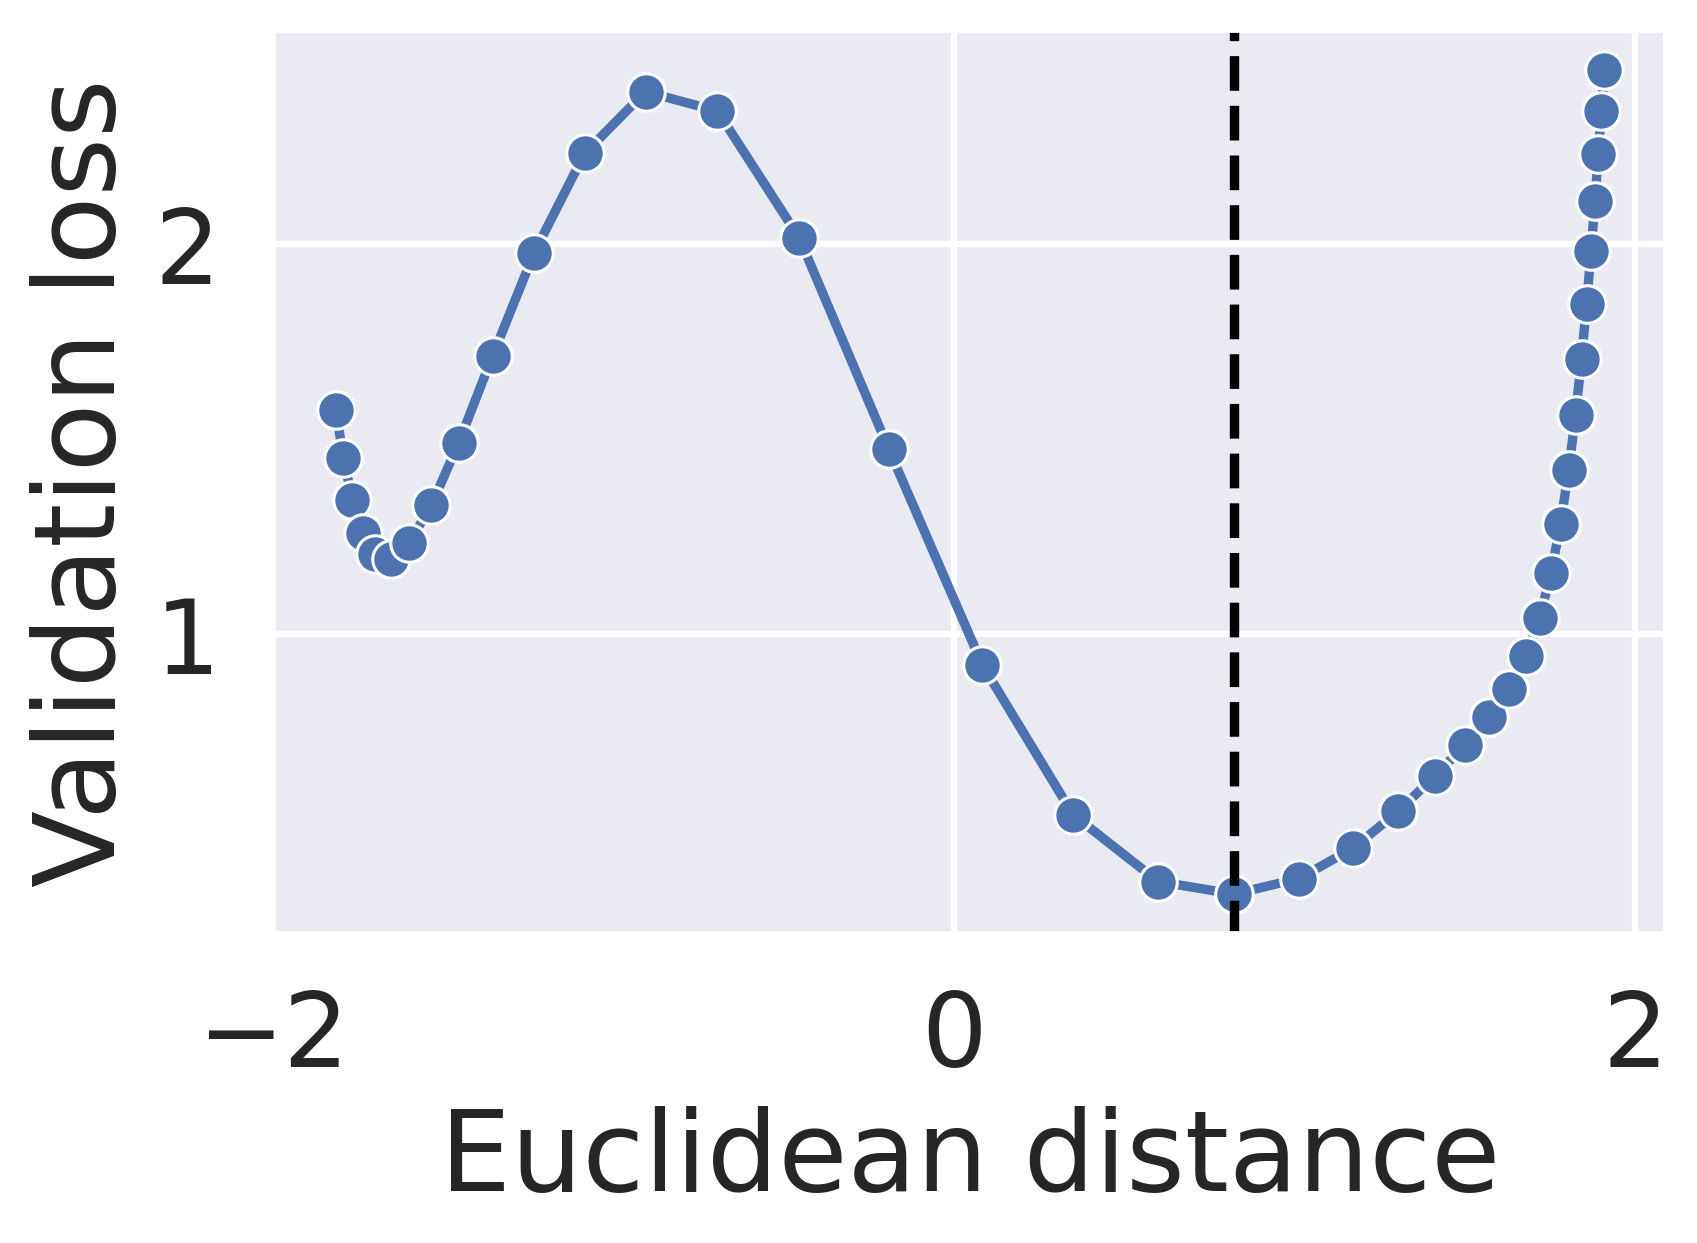

logit_scale 50.0


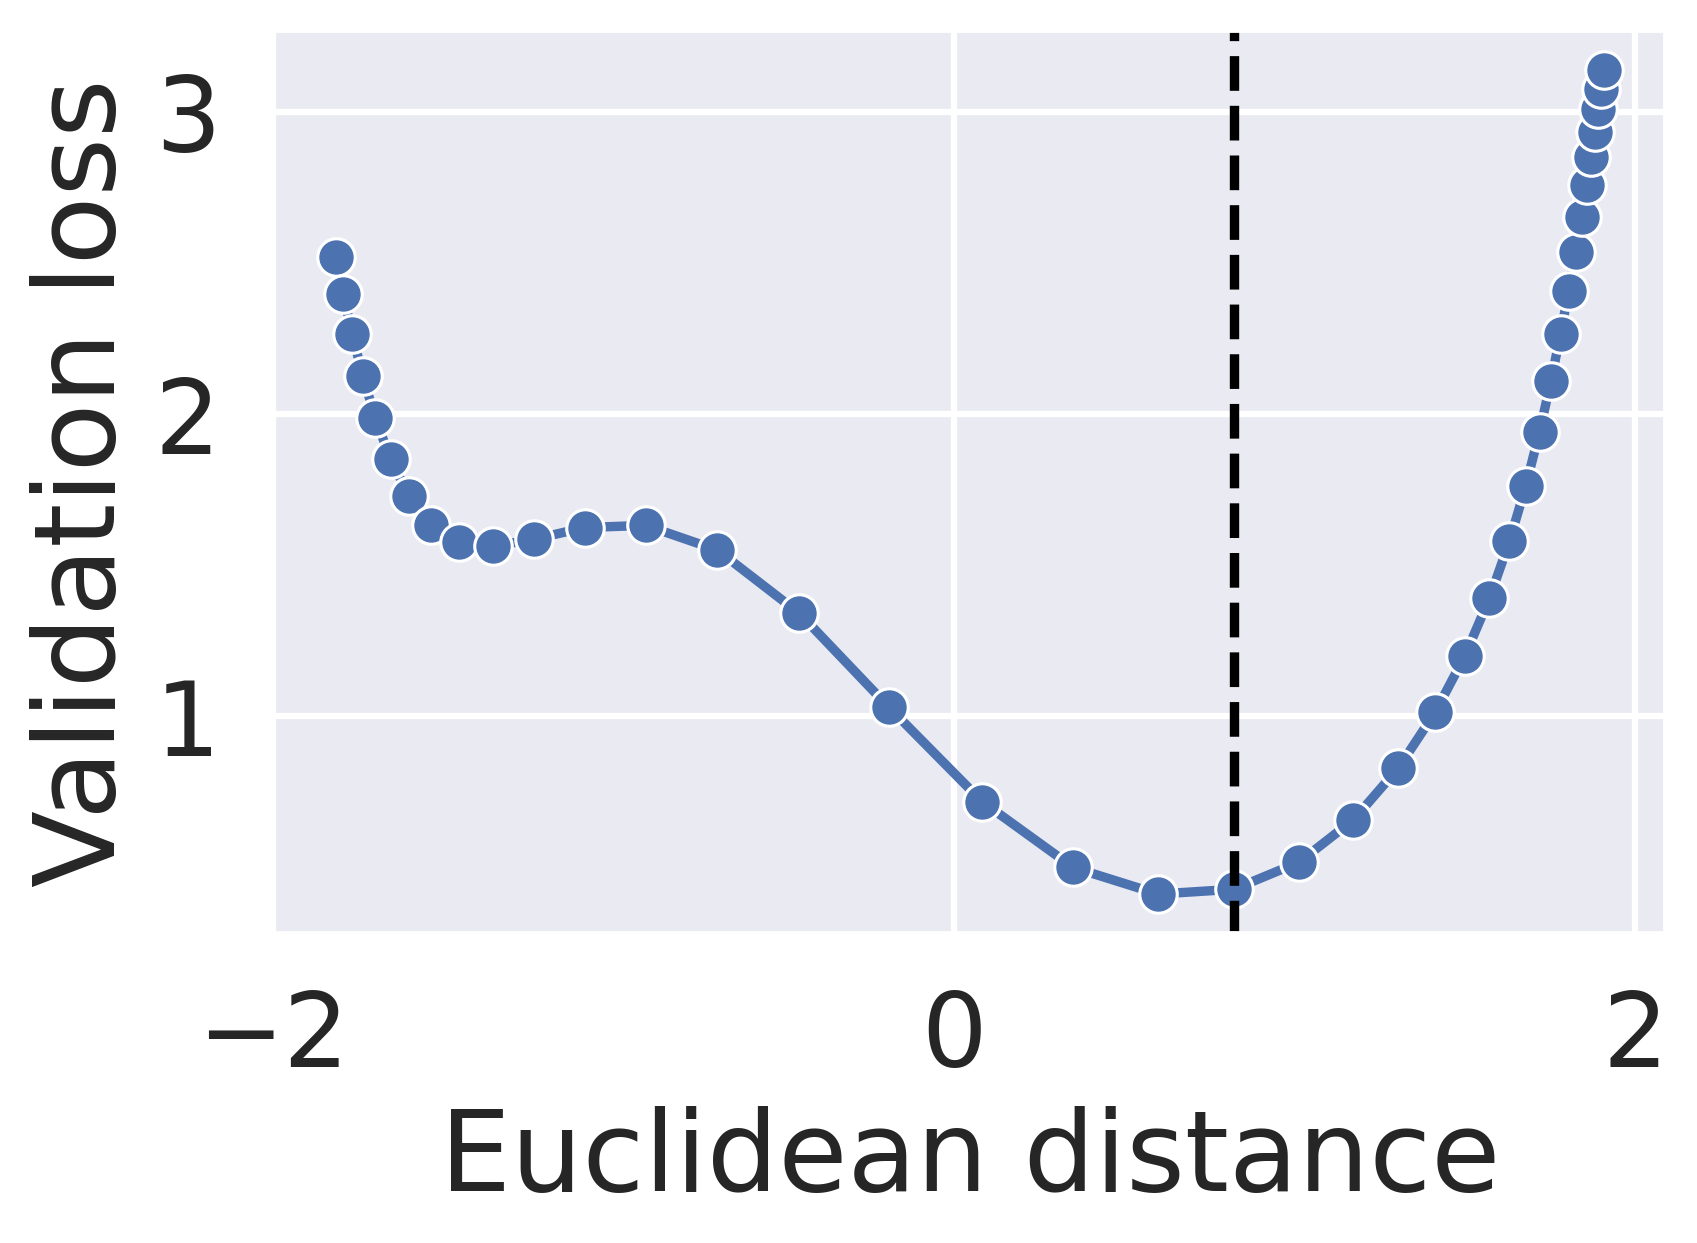

logit_scale 30.0


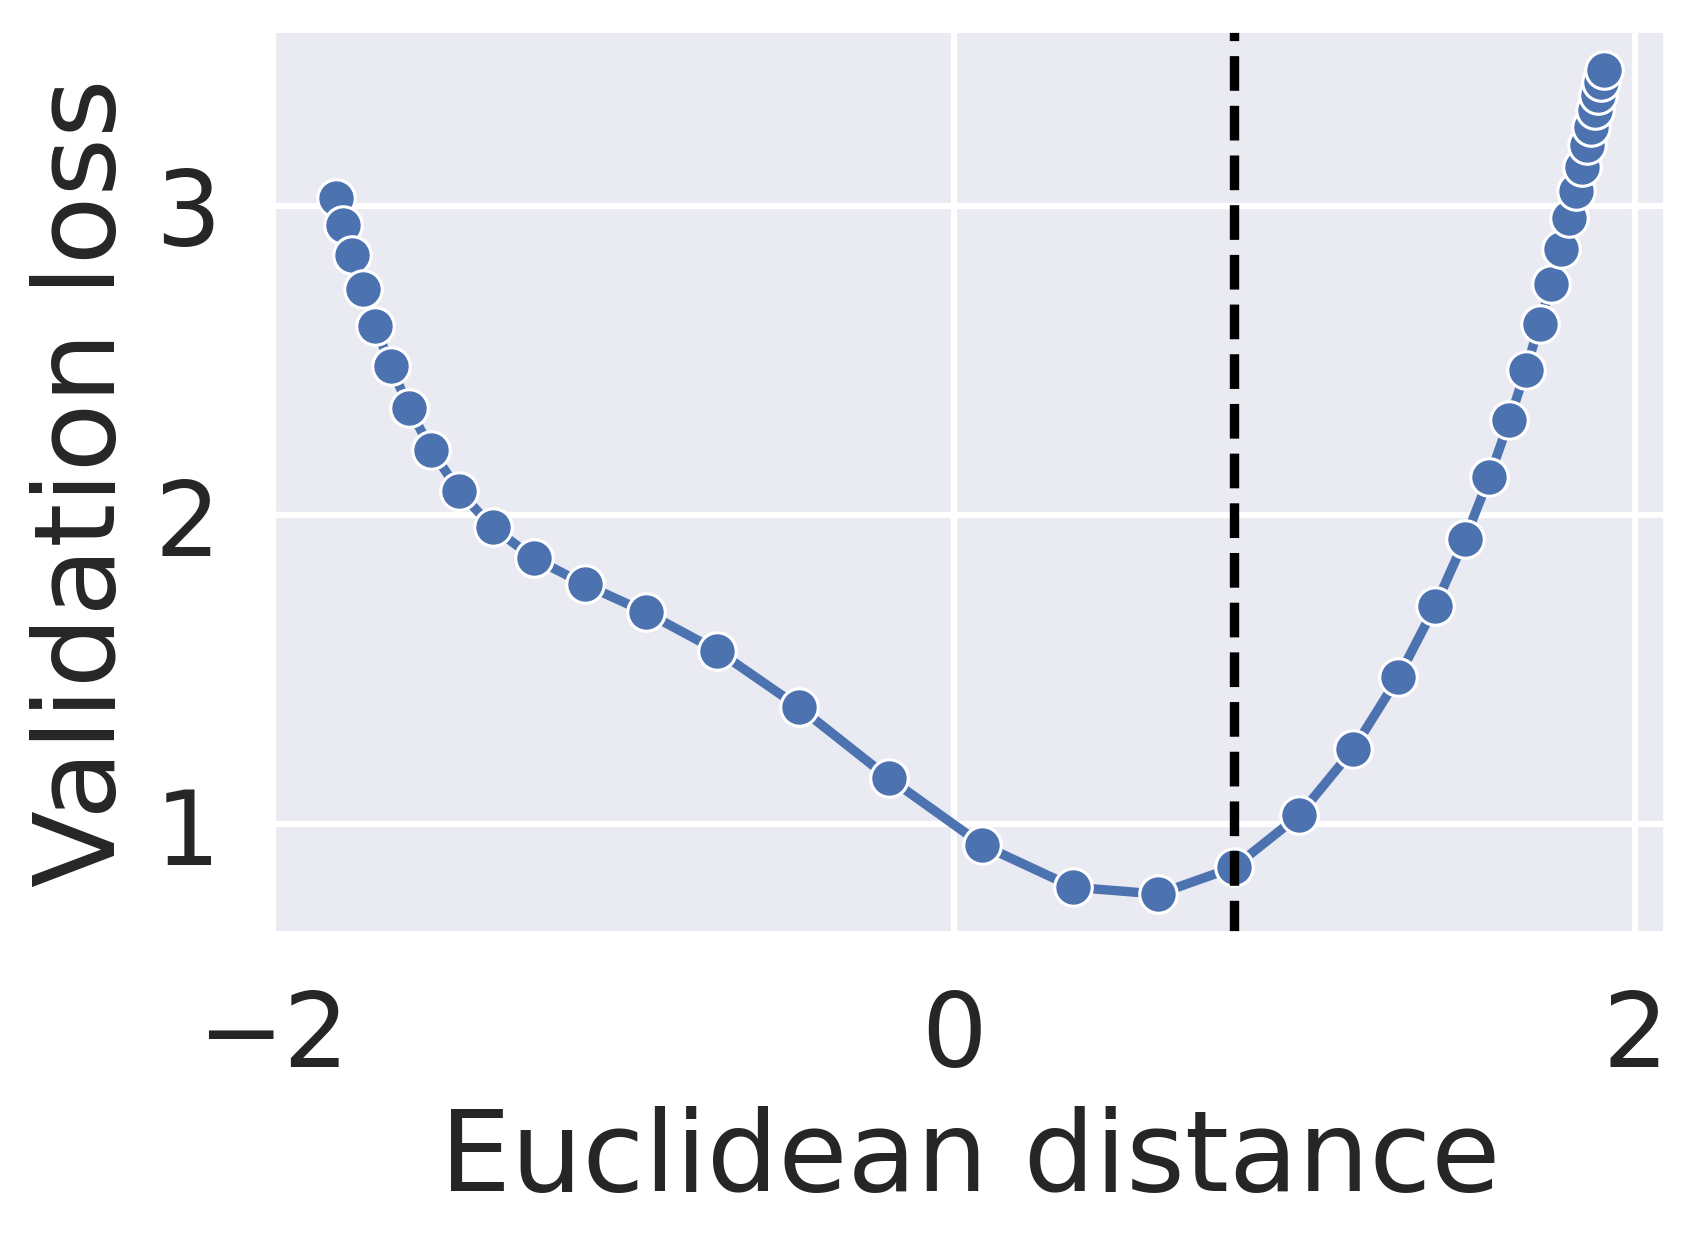

logit_scale 20.0


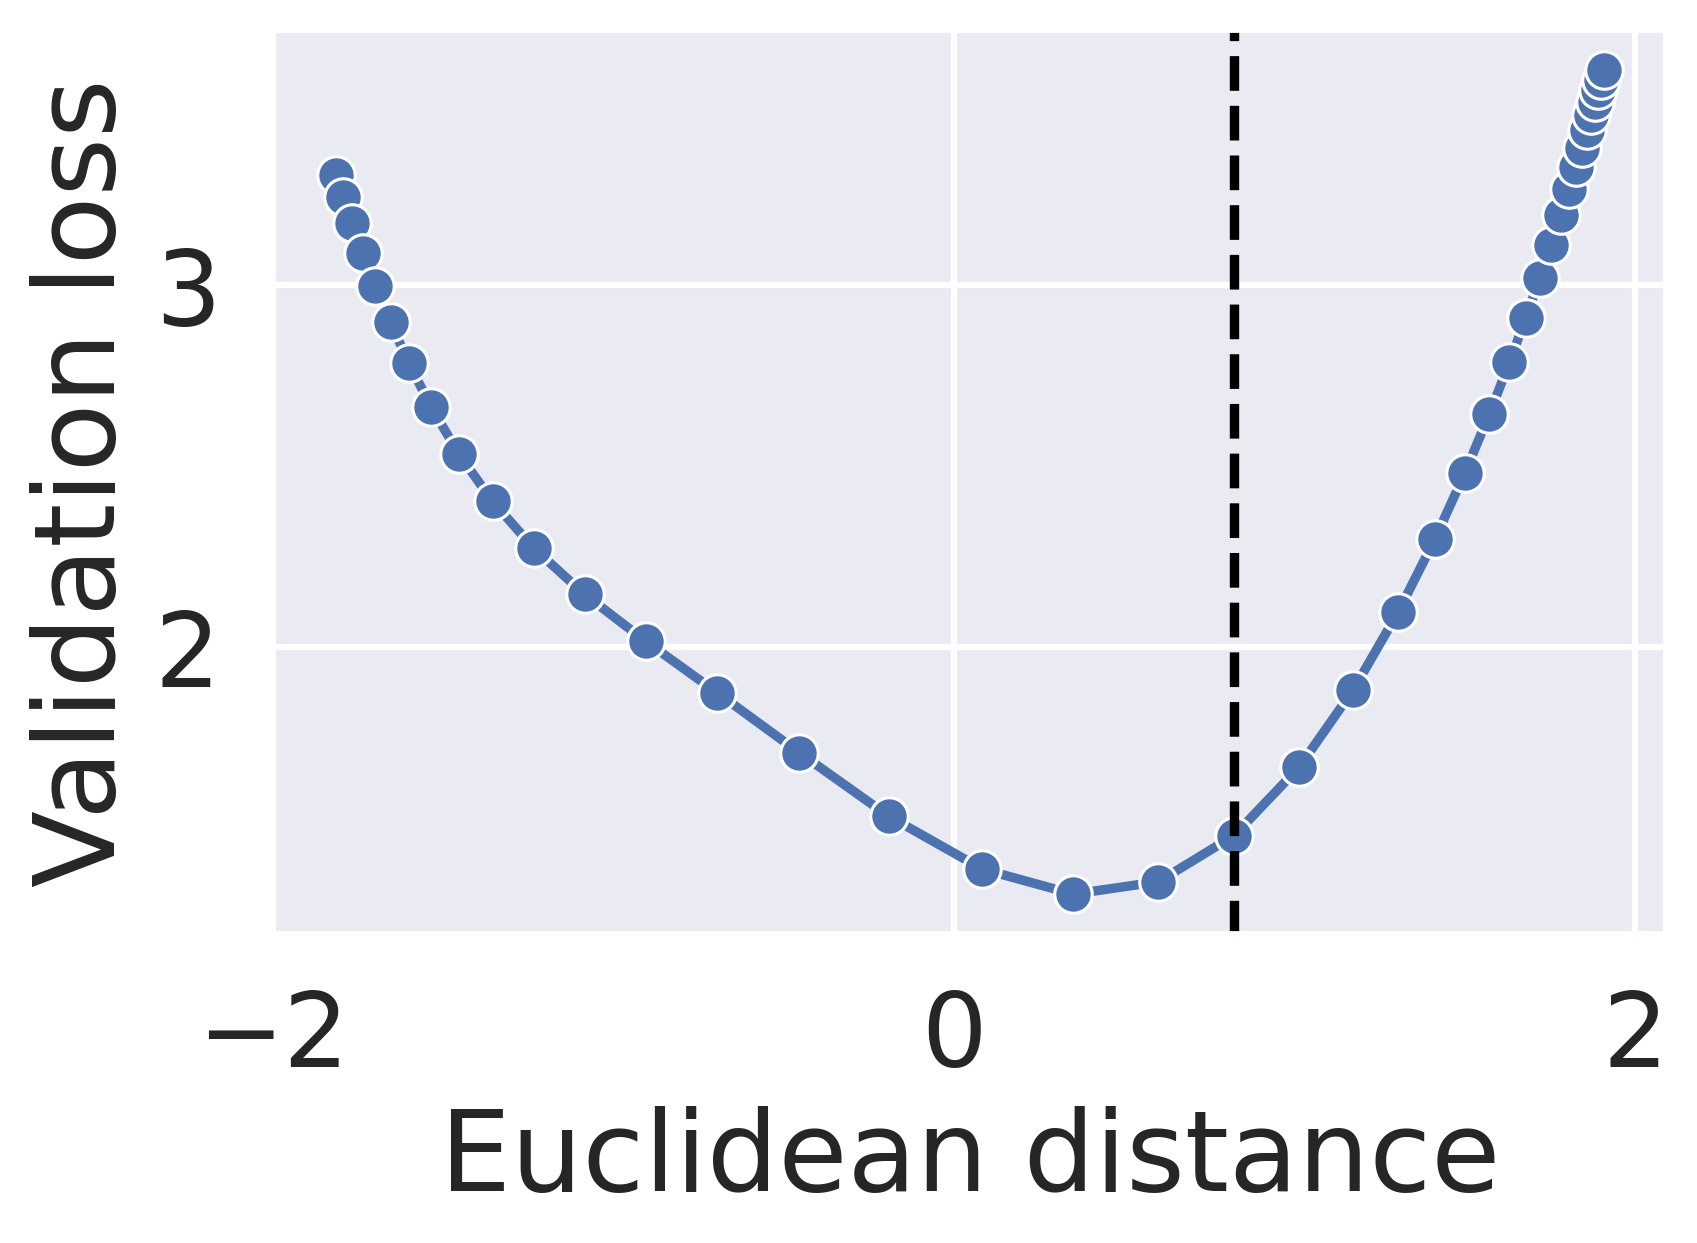

logit_scale 10.0


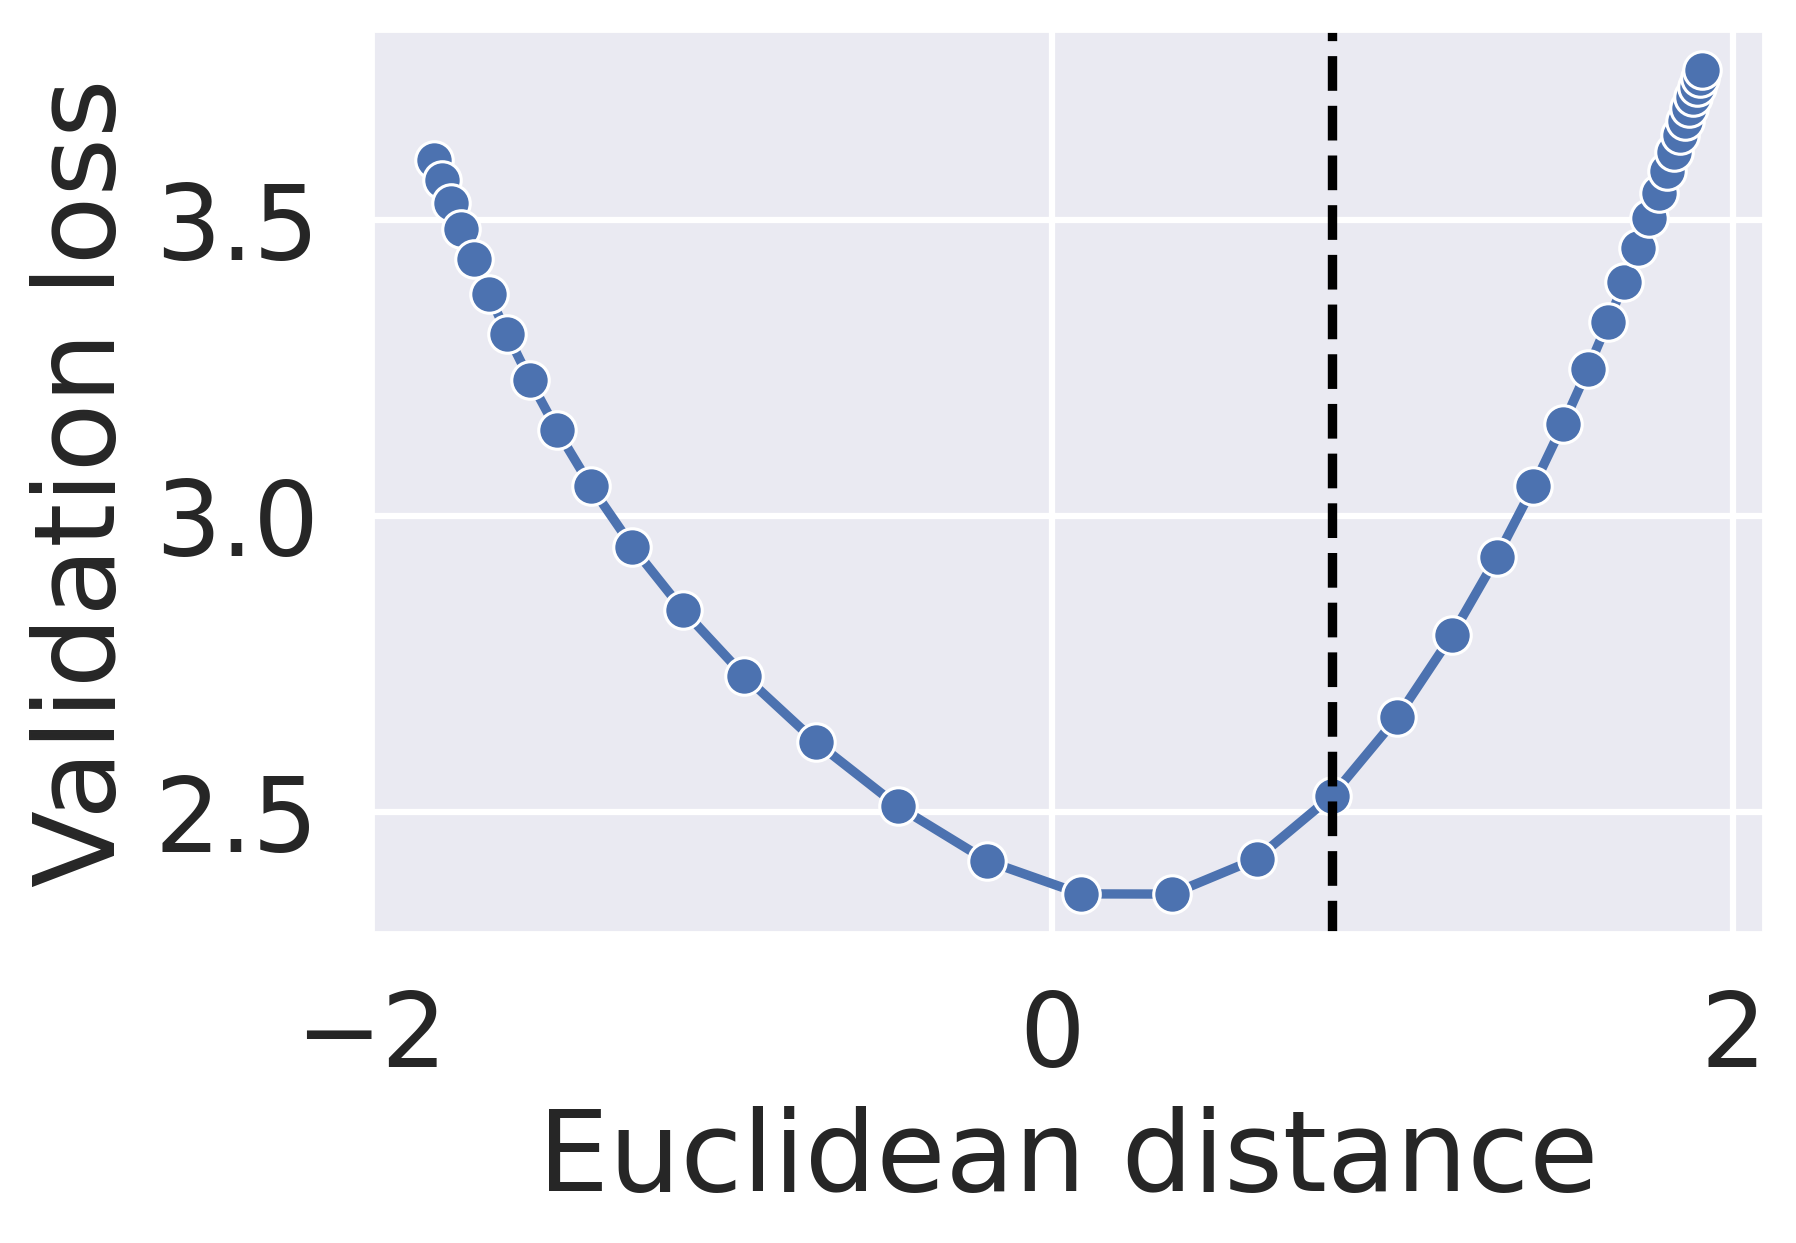

logit_scale 1.0


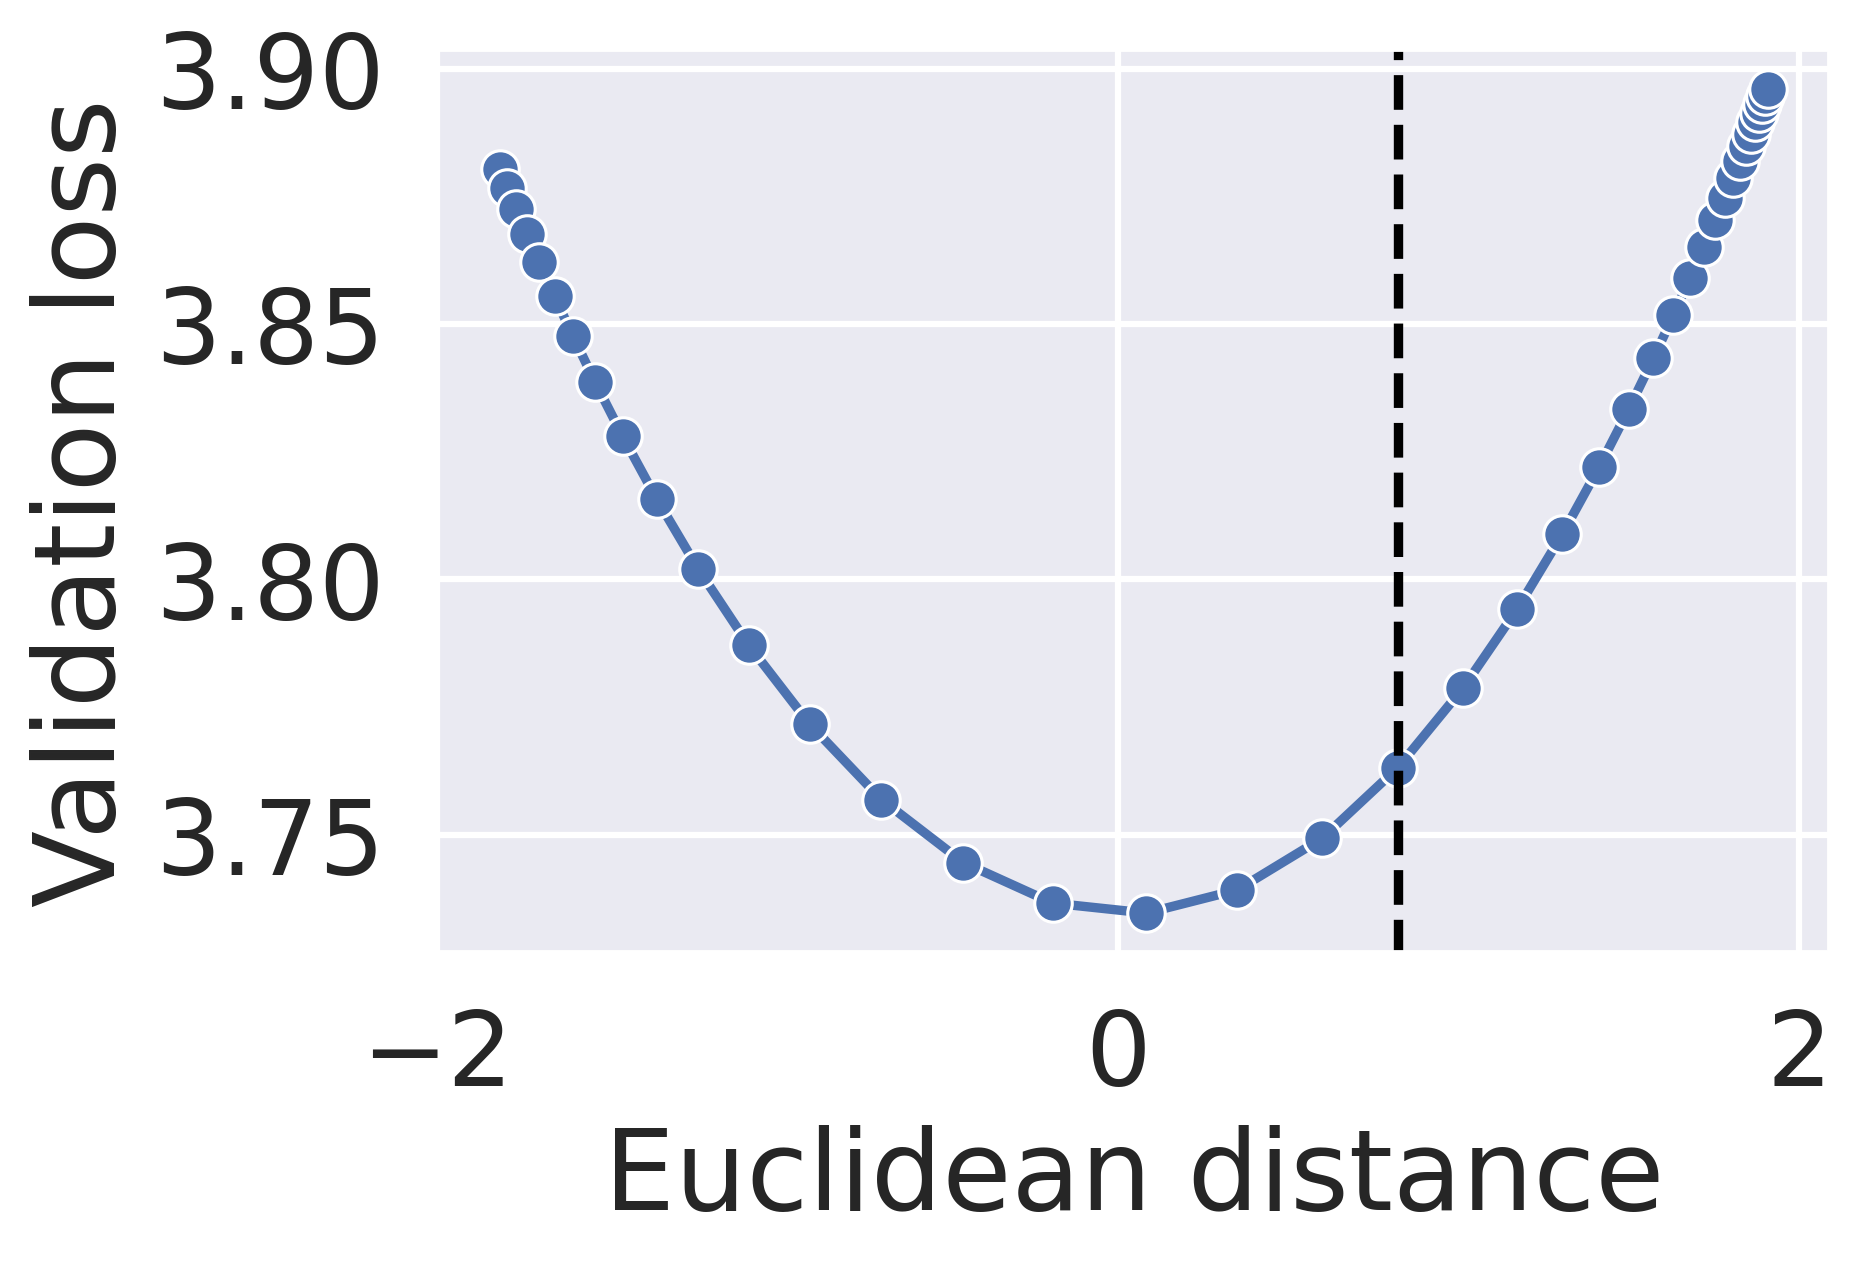

In [21]:
plot_with_logit_scale(logit_scale = 100.00)
plot_with_logit_scale(logit_scale = 50.00)
plot_with_logit_scale(logit_scale = 30.00)
plot_with_logit_scale(logit_scale = 20.00)
plot_with_logit_scale(logit_scale = 10.00)
plot_with_logit_scale(logit_scale = 1.000)